---
title: Process control monitors
author: "Joaquin Matres"
numbersections: true
autoEqnLabels: true
geometry:
- top=30mm
- left=20mm
- right=20mm
- bottom=30mm
bibliography: library.bib
header-includes:
    - \usepackage{float}

---

# Report

## Motivation

As we build more complex photonic systems we need to understand how the
variability of each component affects the performance of the overall system. In
this paper we add process control monitor the width and height control for the
Ebeam process.

Here is a list of components included in the mask

- low and high order MZI to extract group index and effective index
- different length spirals to extract propagation loss (dB/cm) versus wavelength
- ring resonators to extrac group and effective index variations


All the code used, included this report can be found in [this github
repo](https://github.com/gdsfactory/ubc), which contains:

- GDS layout and circuit models for the components
- mask code to build GDS, together with JSON metadata

Links:

- [gdsfactory documentation](https://gdsfactory.readthedocs.io/en/latest/)
[@gdsfactory]
- [simphony](https://simphonyphotonics.readthedocs.io/en/latest/) for circuit
simulation.[@simphony]
- [SiPANN](https://sipann.readthedocs.io/en/latest/) which uses a neural network
to fit the component models. [@sipann]
- [modes](https://modes.readthedocs.io/en/latest/index.html)


## MZI interferometers

We follow the method described in [@Xing2018] to extract the group index and
effective index, where we use a low (m=15) and high order (m=150) MZI to extract
the group and effective index of the waveguide, from which we can extract the
waveguide width and height.


$$m \lambda_{res} = n_{eff} \Delta L$$

$$\Delta L = m \lambda_{res} / n_{eff}$$


According to the ANT [website](https://www.appliednt.com/), waveguides have a
sidewall angle of 82°. The fabricated 500x220 nm waveguides neff is 2.495 and
group index 4.12

In [10]:
import modes
import gdsfactory as gf
import ubcpdk.simulation.circuits_simphony as cm
import gdsfactory.simulation.simphony as gs
import ubcpdk

2022-02-14 15:14:47.988357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 15:14:47.988382: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


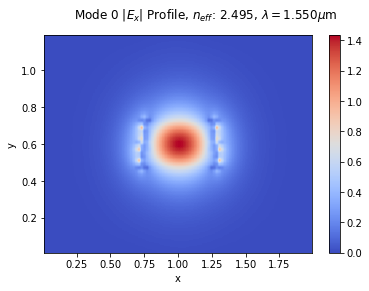

In [2]:
s = modes.mode_solver_full(angle=82,
                           width=500e-3,
                           thickness=220e-3,
                           plot=True,
                           fields_to_write=('Ex',),
                           n_modes=1)

In [3]:
ng = modes.group_index(thickness=220e-3, width=470e-3, angle=82)
print(f'group index ng = {ng[0]:.2f}')

group index ng = 4.12


In [4]:
neff =  2.495
delta_length_short = 15 * 1.55 / neff
delta_length_long = 150 * 1.55 / neff
print(f'MZI short = {delta_length_short:.2f} MZI long = {delta_length_long:.2f}')

MZI short = 9.32 MZI long = 93.19


We can now layout and simulate the MZI responses together with grating couplers.

2022-02-14 15:12:18.450 | INFO     | gdsfactory.show:show:36 - Klayout show mzi_7d268714: uid 3, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references


mzi_7d268714: uid 3, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references


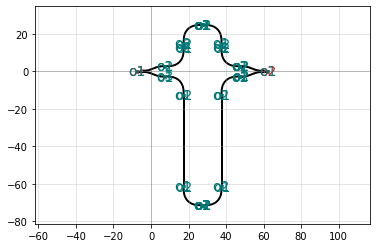

mzi_7d268714: uid 3, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [7]:
ubcpdk.components.mzi(delta_length=delta_length_long)

2022-02-14 15:12:21.246 | INFO     | gdsfactory.show:show:36 - Klayout show mzi_f327a14f: uid 18, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references


mzi_f327a14f: uid 18, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references


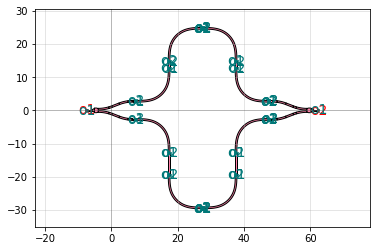

mzi_f327a14f: uid 18, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [8]:
ubcpdk.components.mzi(delta_length=delta_length_short)

2022-02-14 15:13:10.994 | INFO     | gdsfactory.simulation.simphony.components.straight:straight:23 - igoring dict_keys([])
2022-02-14 15:13:10.995 | INFO     | gdsfactory.simulation.simphony.components.straight:straight:23 - igoring dict_keys([])


<AxesSubplot:title={'center':'mzi'}, xlabel='wavelength (nm)', ylabel='|S|'>

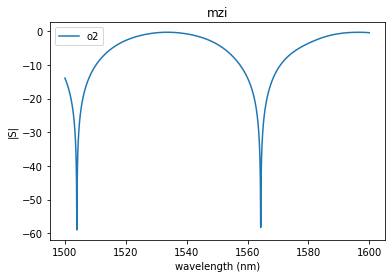

In [10]:

mzi_circuit_short = cm.mzi(delta_length=delta_length_short)
gs.plot_circuit(mzi_circuit_short)

2022-02-14 15:13:16.464 | INFO     | gdsfactory.simulation.simphony.components.straight:straight:23 - igoring dict_keys([])
2022-02-14 15:13:16.465 | INFO     | gdsfactory.simulation.simphony.components.straight:straight:23 - igoring dict_keys([])


<AxesSubplot:title={'center':'mzi'}, xlabel='wavelength (nm)', ylabel='|S|'>

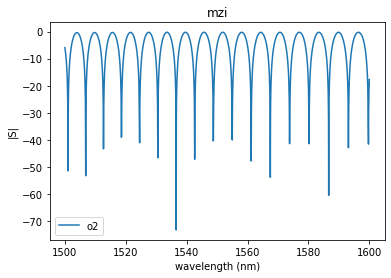

In [12]:
mzi_circuit_long = cm.mzi(delta_length=delta_length_long)
gs.plot_circuit(mzi_circuit_long)

## Ring resonators

We add another method to extract group and effective index using Ring resonators
as described in [@Lu2017].

The ring resonators from the paper had 500 x 220nm waveguides, 4.5um coupler
length, 200nm gap and 12um bend radius.

2022-02-14 15:14:28.903 | INFO     | gdsfactory.show:show:36 - Klayout show ring_single_bc4edf82: uid 1, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references


ring_single_bc4edf82: uid 1, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references


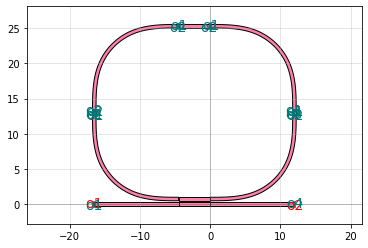

ring_single_bc4edf82: uid 1, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references

In [7]:
ubcpdk.components.ring_single(length_x=4.5, gap=0.2, radius=12)

/home/jmatres/mambaforge/lib/python3.9/site-packages/simphony/library/siepic/__init__.py:440: UserWarning: Exact parameters not available for '<class 'simphony.library.siepic.ebeam_dc_halfring_straight'>', using closest approximation (results may not be as accurate).
Requested: {'gap': 2e-07, 'radius': 1.2e-05, 'width': 5e-07, 'thickness': 2.2e-07, 'couple_length': 4e-06}
Selected:  {'gap': 2e-07, 'radius': 1e-05, 'width': 5e-07, 'thickness': 2.2e-07, 'couple_length': 4e-06}
NOTE: Model attributes may have been automatically modified.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='wavelength (nm)', ylabel='|S (dB)|'>

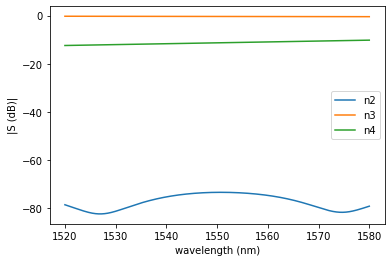

In [11]:
from simphony.library import siepic
import matplotlib.pyplot as plt

c = siepic.ebeam_dc_halfring_straight(
    gap=200e-9,
    radius=12e-6,
    width=500e-9,
    thickness=220e-9,
    couple_length=4e-6
)
gs.plot_model(c, pin_in='n1', pins=('n2', 'n3', 'n4'))

We use [simphony](https://simphonyphotonics.readthedocs.io/en/latest/) for
circuit simulation. As simphony misses Sparameters for some coupler designs, we
use [SiPANN](https://sipann.readthedocs.io/en/latest/) which uses a neural
network to interpolate missing Sparameter values.

In [12]:
import numpy as np
from SiPANN import nn


def f(radius,
      couplerLength,
      gap,
      width,
      thickness,
      sw_angle,
      couplerWidth,
      wavelength=np.squeeze(np.linspace(1.5,1.6,5000))):
    """ units in um
    """    
    E, alpha, t, alpha_s, _ = nn.racetrack_AP_RR_TF(wavelength,
                                                    widthCoupler=couplerWidth,
                                                    radius=radius,
                                                    sw_angle=sw_angle,
                                                    couplerLength=couplerLength,
                                                    gap=gap,
                                                    width=width,
                                                    thickness=thickness)
   
    input       = np.squeeze([1,0])
    throughPort = 10*np.log10(np.abs(np.squeeze(E)) ** 2)
    #throughPort = np.unwrap(np.angle(np.squeeze(E)))

    plt.figure()
    plt.plot(wavelength, (throughPort), label='Through Port')
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (a.u.)')
    plt.grid(True)
    plt.title(f'couplerLength = {couplerLength}')
    plt.legend()
    #plt.ylim(-30, 0.1)
    #plt.xlim(1.55,1.56)
    plt.tight_layout()
    plt.show()

INFO:tensorflow:Restoring parameters from /home/jmatres/mambaforge/lib/python3.9/site-packages/SiPANN/ANN/TIGHT_ANGLE_GAP/model


2022-02-14 15:14:54.575610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-14 15:14:54.575635: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-14 15:14:54.575653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jmatres-glaptop): /proc/driver/nvidia/version does not exist
2022-02-14 15:14:54.576396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Restoring parameters from /home/jmatres/mambaforge/lib/python3.9/site-packages/SiPANN/ANN/TIGHT_ANGLE_STRAIGHT/model
INFO:tensorflow:Restoring parameters from /home/jmatres/mambaforge/lib/python3.9/site-packages/SiPANN/ANN/TIGHT_ANGLE_BENT_RAND/model


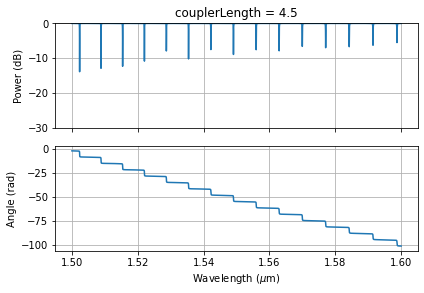

In [14]:
f(radius=12, couplerLength=4.5, gap=0.2, width=0.5, thickness=.22, sw_angle=82, couplerWidth=.5)

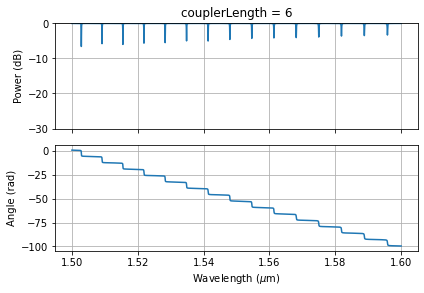

In [15]:
f(radius=12, couplerLength=6, gap=0.2, width=0.5, thickness=.22, sw_angle=82, couplerWidth=.5)

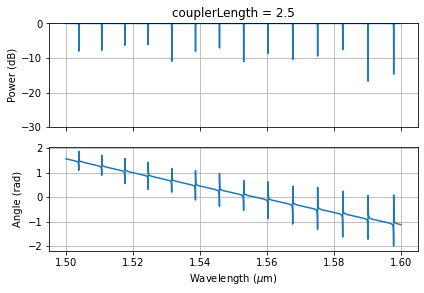

In [16]:
f(radius=12, couplerLength=2.5, gap=0.2, width=0.5, thickness=.22, sw_angle=82, couplerWidth=.5)

As we can see it's hard to distinguish undercoupled from overcoupled regimes, so
we plot both amplitude and phase.

In [13]:
import numpy as np
from SiPANN import nn

wavelength = np.squeeze(np.linspace(1.5,1.6,5000))

def f(radius,couplerLength,gap,width,thickness,sw_angle,couplerWidth):
    """ units in um
    """
    E, alpha, t, alpha_s, _ = nn.racetrack_AP_RR_TF(wavelength,
                                                    widthCoupler=couplerWidth,
                                                    radius=radius,
                                                    sw_angle=sw_angle,
                                                    couplerLength=couplerLength,
                                                    gap=gap,
                                                    width=width,
                                                    thickness=thickness)


    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # Evaluate response
    input       = np.squeeze([1,0])
    throughPort = 10*np.log10(np.abs(np.squeeze(E)) ** 2)
    throughPort_angle = np.unwrap(np.angle(np.squeeze(E)))

    ax1.plot(wavelength, (throughPort), label='Through Port')
    ax1.set_ylabel('Power (dB)')
    ax1.grid()
    
    ax2.plot(wavelength, (throughPort_angle), label='Through Port')
    
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    #plt.legend()
    ax1.set_ylim(-30, 0.1)
    #plt.xlim(1.55,1.56)
    plt.tight_layout()
    ax1.set_title(f'couplerLength = {couplerLength}')

    plt.show()

In [ ]:
f(radius=12, couplerLength=4.5, gap=0.2, width=0.5, thickness=.22, sw_angle=82, couplerWidth=.5)

In [ ]:
f(radius=12, couplerLength=2.5, gap=0.2, width=0.5, thickness=.22, sw_angle=82, couplerWidth=.5)

In [ ]:
f(radius=12, couplerLength=6.5, gap=0.2, width=0.5, thickness=.22, sw_angle=82, couplerWidth=.5)

## Spirals for waveguide loss

For measuring waveguide loss for different wavelengths we added 3 spirals with
different length

2022-02-14 15:15:41.952 | INFO     | gdsfactory.show:show:36 - Klayout show spiral_external_io_fd50ad9e: uid 17, ports ['o2', 'o1'], aliases [], 0 polygons, 237 references


spiral 1 length = 1.57 cm
spiral_external_io_fd50ad9e: uid 17, ports ['o2', 'o1'], aliases [], 0 polygons, 237 references


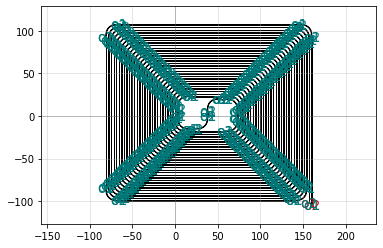

spiral_external_io_fd50ad9e: uid 17, ports ['o2', 'o1'], aliases [], 0 polygons, 237 references

In [19]:
N = 15
radius = 15

s1 = gf.components.spiral_external_io(
    N=N,
    radius=radius,
    y_straight_inner_top=0,
    x_inner_length_cutback=0,
)

s2 = gf.components.spiral_external_io(
    N=N,
    radius=radius,
    y_straight_inner_top=30,
    x_inner_length_cutback=85,
)

print(f"spiral 1 length = {s1.info['length']/1e4:.2f} cm")
s1

2022-02-14 15:15:57.649 | INFO     | gdsfactory.show:show:36 - Klayout show spiral_external_io_39c769e7: uid 141, ports ['o2', 'o1'], aliases [], 0 polygons, 237 references


spiral 2 length = 2.22 cm
spiral_external_io_39c769e7: uid 141, ports ['o2', 'o1'], aliases [], 0 polygons, 237 references


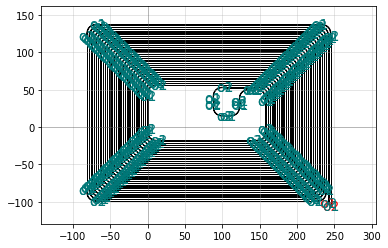

spiral_external_io_39c769e7: uid 141, ports ['o2', 'o1'], aliases [], 0 polygons, 237 references

In [20]:
print(f"spiral 2 length = {s2.info['length']/1e4:.2f} cm")
s2

## References

- [1] “Gdsfactory — gdsfactory documentation.” [Online]. Available:
https://gdsfactory.readthedocs.io/en/latest/.
- [2] “Simphony Documentation — Simphony Manual.” [Online]. Available:
https://simphonyphotonics.readthedocs/io/en/latest/.
- [3] “SiPANN documentation.” [Online]. Available:
https://sipann.readthedocs.io/en/latest/.
- [4] Y. Xing, J. Dong, S. Dwivedi, U. Khan, and W. Bogaerts, “Accurate
extraction of fabricated geometry using optical measurement,” Photonics
Research, vol. 6, no. 11, p. 1008, 2018, doi: 10.1364/prj.6.001008.
- [5] Z. Lu et al., “Performance prediction for silicon photonics integrated
circuits with layout-dependent correlated manufacturing variability,” Optics
Express, vol. 25, no. 9, p. 9712, 2017, doi: 10.1364/oe.25.009712.
- [6] [Modes documentation](https://modes.readthedocs.io/en/latest/index.html)